##Pôle Projet
##Predictive maintenance for turbofan engine
## Groupe 08
## Members:
#### Lucas FERNANDES MARTINS
### Vitor OPSFELDER ESTANISLAU
### Eliott BINARD
### Klara Juliette TJERNSTROM

#### Clients:
#### MathWorks, CentraleSupélec, Utrecht University



##### Imports and installs

In [ ]:
!pip install feature-engine
!pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint
from feature_engine import transformation as vt
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Loading dataset
#Defining feature names
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

#Load dataset
data = pd.read_csv('/content/drive/MyDrive/Livrable_Gr_8/CMAPSSData/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)


## Preprocessing

#### In this section, we processed the data by doing some operations, such as Yeo Johnson transformation and scalling. Also, some diagnostic plots were made to evaluate the transformations and its effects on data. Also some constants features were dropped.

#### Normalizing data and feature selection

In [ ]:
data

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [ ]:
# dropping constant features and adding import features to data set
from sklearn.model_selection import train_test_split
drop_features=['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']
setting_names = ['setting_1', 'setting_2', 'setting_3']
drop_labels = setting_names+drop_features
drop_indexes = ['unit_number',  'time_cycles']
data=data.drop(columns=drop_labels).copy()

data

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [ ]:
sensors = [s for s in sensor_names if s not in drop_features]
sensors

['s_2',
 's_3',
 's_4',
 's_7',
 's_8',
 's_9',
 's_11',
 's_12',
 's_13',
 's_14',
 's_15',
 's_17',
 's_20',
 's_21']

In [ ]:
# Compute the RUL for the dataset
def calcul_RUL(df):
    max_cycles = df[index_names].groupby('unit_number')['time_cycles'].max()
    df = df.merge(max_cycles.to_frame(name='max_cycles'), left_on='unit_number', right_index=True)
    df['RUL'] = df['max_cycles'] - df['time_cycles']
    df = df.drop('max_cycles', axis=1)
    return df

data = calcul_RUL(data)

data_test = data.copy()

In [ ]:
data_test

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [ ]:
def diagnostic_plots(df,variable):
    #function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(data=df, x=variable, kde=True,color='#3498db',stat="density")
    plt.title('Histogram')

    # Q-Q plot
    ax=plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    ax.get_lines()[0].set_markersize(7.0)
    ax.get_lines()[0].set_markerfacecolor('#44B1A5')
    ax.get_lines()[0].set_color('#44B1A5')

    ax.get_lines()[1].set_markerfacecolor('#FF7627')
    plt.ylabel('RM quantiles')
    plt.show()

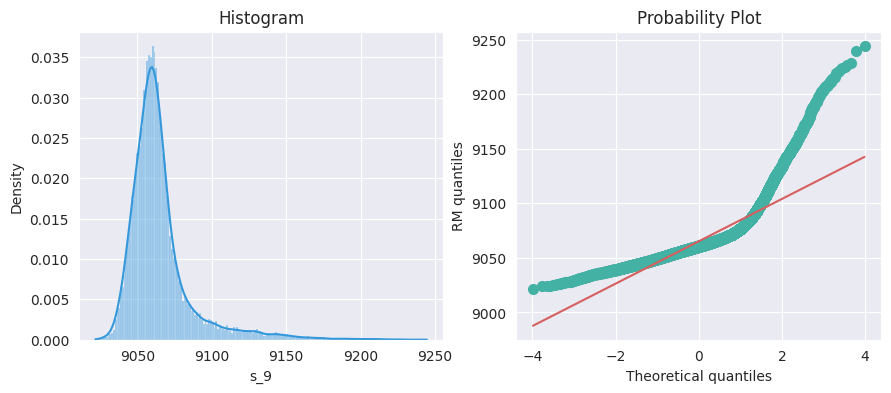

In [ ]:
warnings.filterwarnings('ignore')
for feature in ['s_9']:
  diagnostic_plots(data,feature)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scalling the data by normalizing it
scaler=MinMaxScaler()

dropped = data.drop(columns=['unit_number','time_cycles','RUL'])
scaler.fit(dropped)
norm=pd.DataFrame(scaler.transform(dropped),
                     columns=dropped.columns,index=dropped.index)
norm['unit_number'] = data['unit_number']
norm['time_cycles'] = data['time_cycles']
norm['RUL'] = data['RUL']
data = norm
del norm
data

,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,unit_number,time_cycles,RUL
0,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,1,1,191
1,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,1,2,190
2,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,1,3,189
3,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,1,4,188
4,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,1,5,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.686747,0.587312,0.782917,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500,100,196,4
20627,0.701807,0.729453,0.866475,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197,100,197,3
20628,0.665663,0.684979,0.775321,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991,100,198,2
20629,0.608434,0.746021,0.747468,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466,100,199,1


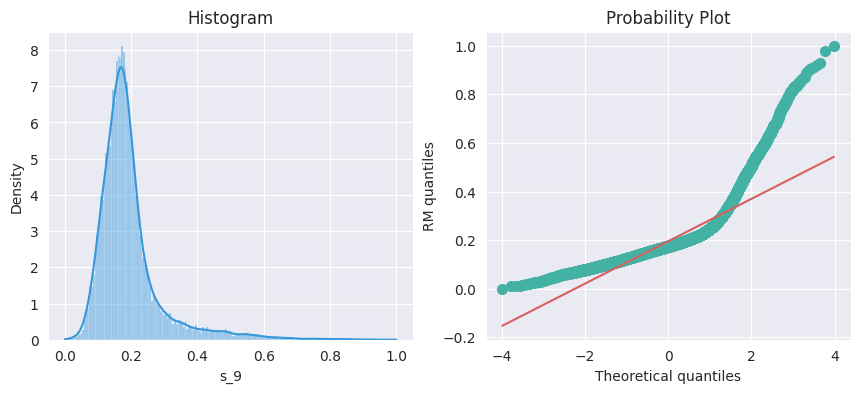

In [ ]:
warnings.filterwarnings('ignore')
for feature in ['s_9']:
  diagnostic_plots(data,feature)


In [ ]:
def view_tranformations(X_train,columns_names,transformation_name='YeoJohnson'):

  df_before = pd.DataFrame({'Skew':[X_train[feature].skew() for feature in columns_names],
                              'Feature':[feature for feature in columns_names]})

  if transformation_name in ['log','Log','LOG','ln','natural_log']:
    tf = vt.LogTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                             'Feature':[feature for feature in columns_names]})
    label='Skewness before and after Log-Transformation'
  elif transformation_name in ['boxcox','Boxcox','box cox','box-cox','Box-cox','Box cox']:
    tf = vt.BoxCoxTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                                'Feature':[feature for feature in columns_names]})
    label='Skewness before and after Boxcox-Transformation'
  elif transformation_name in ['YeoJohnson','Yeo Johnson','Yeo-Johnson','yeojohnson','yeo johnson','yeo-johnson']:
    tf = vt.YeoJohnsonTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                                'Feature':[feature for feature in columns_names]})
    label='Skewness before and after YeoJohnson-Transformation'
  elif transformation_name in ['Reciprocal','Inverse','reciprocal','inverse','inverso','reciproco']:
    tf = vt.ReciprocalTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                                'Feature':[feature for feature in columns_names]})
    label='Skewness before and after Reciprocal-Transformation'
  else:
    raise Exception('\nLog\nBox-Cox\nYeo-Johnson\nReciprocal')


  f, ax = plt.subplots(figsize=(6, 6))
  # Plot the total crashes
  sns.set_color_codes("muted")
  sns.set_style('darkgrid')
  sns.barplot(x="Skew", y="Feature", data=df_before,
              label="Before", alpha=0.5)

  # Plot the crashes where alcohol was involved
  sns.set_color_codes("muted")
  sns.barplot(x="Skew", y="Feature", data=df_after,
              label="After",alpha=1)

  # Add a legend and informative axis label
  ax.legend(ncol=2, loc="best", frameon=True)
  ax.set(ylabel="",
        xlabel=label)
  sns.despine(left=True, bottom=True)
  plt.grid()
  plt.show()

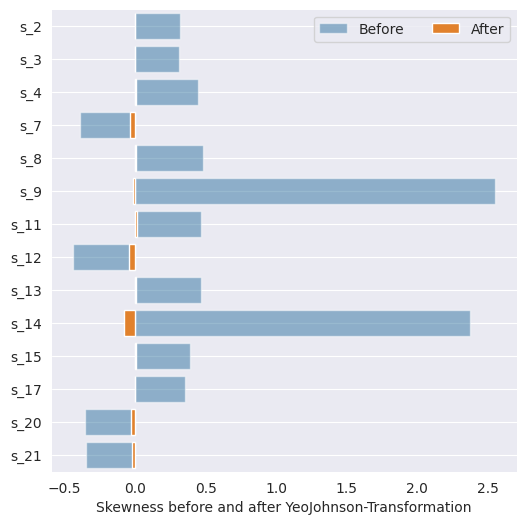

In [ ]:
view_tranformations(data,sensors)

In [ ]:
# Yeo-johnson transformation to reduce skewness
yeojohnson_transform=vt.YeoJohnsonTransformer(variables=sensors)
yeojohnson_transform.fit(data)
data=yeojohnson_transform.transform(data)

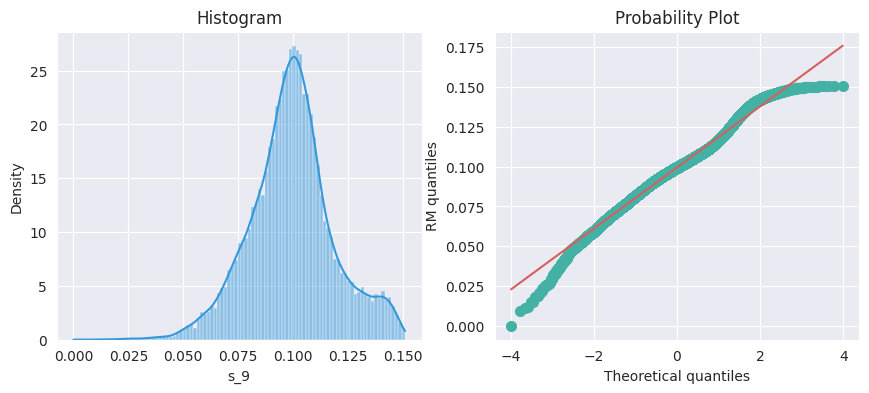

In [ ]:
warnings.filterwarnings('ignore')
for feature in ['s_9']:
  diagnostic_plots(data,feature)

In [ ]:
# Robust scalling to deal with outliers
from sklearn.preprocessing import RobustScaler

scaler=RobustScaler()

dropped = data.drop(columns=['unit_number','RUL'])
scaler.fit(dropped)
norm=pd.DataFrame(scaler.transform(dropped),
                     columns=dropped.columns,index=dropped.index)
norm['unit_number'] = data['unit_number']
norm['RUL'] = data['RUL']
norm['time_cycles'] = data['time_cycles']
data = norm
del norm
data

,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,time_cycles,unit_number,RUL
0,-1.355261,-0.049550,-0.663064,0.827954,-0.348801,-1.112874,-0.116787,0.186276,-0.757254,-0.130608,-0.399259,-0.521136,0.997796,0.896266,1,1,191
1,-0.774393,0.209125,-0.424769,0.265947,-0.596032,-1.320506,-0.057957,0.884234,-0.203946,-0.680343,-0.142433,-0.521136,0.722909,0.932616,2,1,190
2,-0.446680,-0.265448,-0.329137,0.732251,-0.113469,-0.534146,-0.758055,1.054226,-0.641269,-0.536029,-0.435810,-1.718829,0.501761,0.328948,3,1,189
3,-0.446680,-0.966117,-0.542261,0.915298,0.219029,-0.816091,-1.273754,1.619120,-0.100816,-0.487864,-1.634337,-0.521136,0.204129,0.548869,4,1,188
4,-0.414829,-0.957621,-0.152730,0.490007,-0.348801,-0.368683,-0.723498,0.777396,-0.528040,-0.490254,-0.191520,0.000000,0.287750,0.782023,5,1,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,1.149507,0.909987,1.405292,-1.421093,1.001981,0.279893,1.336175,-1.606795,1.423292,-0.202808,1.007686,1.712282,-1.206488,-1.845822,196,100,4
20627,1.210852,1.580910,1.674883,-1.734353,1.345517,0.257750,1.276153,-1.487020,1.131010,-0.282955,1.291325,0.920961,-1.748357,-0.884702,197,100,3
20628,1.062571,1.378043,1.379701,-1.692638,1.427061,0.300188,1.375595,-1.262952,1.279956,0.033571,1.993873,2.068488,-1.358015,-2.020762,198,100,2
20629,0.820160,1.654955,1.284228,-1.825578,1.506973,0.673228,1.915503,-1.493490,1.206205,-0.084259,1.651872,0.920961,-1.774356,-1.409612,199,100,1


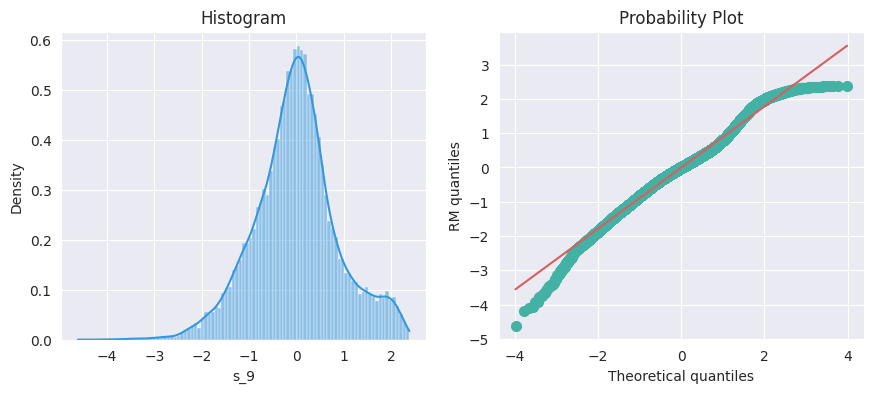

In [ ]:
warnings.filterwarnings('ignore')
for feature in ['s_9']:
  diagnostic_plots(data,feature)

#### Split data into train and test

In [ ]:
machines = data.groupby('unit_number')

n_groups = len(machines)

n_train = int(n_groups*0.7)
indices = np.array([* range(1,n_groups+1)])
indices_train = np.random.choice(indices, n_train, replace=False)
indices_test = np.setdiff1d(indices, indices_train)

machines_train = [group[1].sort_values(by='time_cycles') for i, group in enumerate(machines) if i+1 in indices_train]
machines_test = [group[1].sort_values(by='time_cycles') for i, group in enumerate(machines) if i+1 in indices_test]

<Axes: >

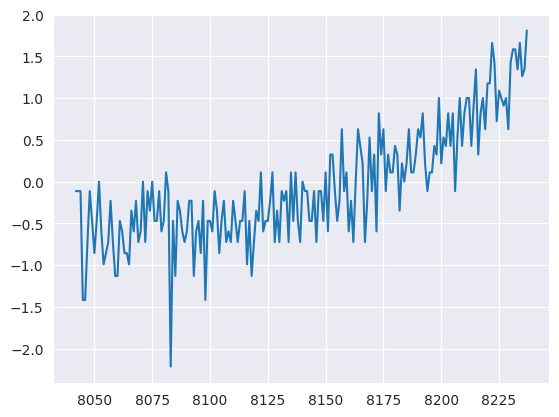

In [ ]:
machines_train[30][sensors[4]].plot()

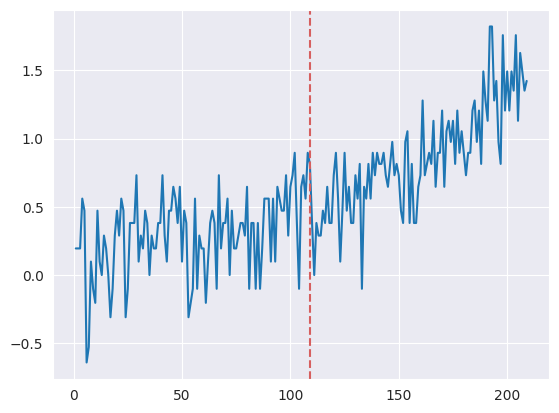

In [ ]:
index_machine = 11
index_sensor = 8
avr = machines_train[index_machine][sensors[index_sensor]]
time = machines_train[index_machine]['time_cycles'].tolist()
plt.plot(time, avr)
plt.axvline(x=time[-1]-100, color='r', linestyle='--')

## Model training and validation

#### Convert to classification problem

In [ ]:
# divide in classes the RUL
def transform_rul_to_rulw(rul):
    rul = int(rul)
    rulw = rul//7
    if rulw>4:
        rulw=5
    y = np.zeros(6)
    y[rulw] = 1
    return y

In [ ]:
dataset = data.sort_values(by=['RUL']).drop(columns=['time_cycles', 'unit_number'])
name_classes = ['0','1','2', '3','4', '4+']
classes = pd.DataFrame(dataset['RUL'].apply(transform_rul_to_rulw).tolist(), columns=name_classes)
dataset = pd.concat([dataset, classes], axis=1)
dataset = dataset.drop(columns=['RUL'])
#initial training data
n_train = 1000

dataset_train = dataset[:n_train]
dataset_test = dataset[n_train:]

X_train = dataset_train.drop(columns=name_classes)
y_train = dataset_train[name_classes]

X_test = dataset_test.drop(columns=name_classes)
y_test = dataset_test[name_classes]

#Convert to int for classification
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [ ]:
# Testing diferent classes to find the optimal number
n_classes = 6

resolution = 30
def test_different_classes(n_classes):

  def transform_rul_to_rulw_nclasses(rul):
    rul = int(rul)
    rulw = rul//resolution
    if rulw>(n_classes-2):
        rulw=n_classes-1
    y = np.zeros(n_classes)
    y[rulw] = 1
    return y

  dataset = data.sort_values(by=['RUL']).drop(columns=['time_cycles', 'unit_number'])
  name_classes = [str(num) for num in range(n_classes)]
  classes = pd.DataFrame(dataset['RUL'].apply(transform_rul_to_rulw_nclasses).tolist(), columns=name_classes)
  dataset = pd.concat([dataset, classes], axis=1)
  dataset = dataset.drop(columns=['RUL'])
  #initial training data
  n_train = 1000

  dataset_train = dataset[:n_train]
  dataset_test = dataset[n_train:]

  X_train = dataset_train.drop(columns=name_classes)
  y_train = dataset_train[name_classes]

  X_test = dataset_test.drop(columns=name_classes)
  y_test = dataset_test[name_classes]

  #Convert to int for classification
  y_train = y_train.astype(int)
  y_test = y_test.astype(int)

  return X_train, y_train, X_test, y_test


In [ ]:
X_train, y_train, X_test, y_test = test_different_classes(6)

In [ ]:
n_classes = 6
def transform_rul_to_rulw_nclasses(rul):
    rul = int(rul)
    rulw = rul//7
    if rulw>(n_classes-2):
        rulw=n_classes-1
    y = np.zeros(n_classes)
    y[rulw] = 1
    return y

dataset = data.sort_values(by=['RUL']).drop(columns=['time_cycles', 'unit_number'])

name_classes = [str(num) for num in range(n_classes)]
classes = pd.DataFrame(dataset['RUL'].apply(transform_rul_to_rulw_nclasses).tolist(), columns=name_classes)
classes

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
20626,0.0,0.0,0.0,0.0,0.0,1.0
20627,0.0,0.0,0.0,0.0,0.0,1.0
20628,0.0,0.0,0.0,0.0,0.0,1.0
20629,0.0,0.0,0.0,0.0,0.0,1.0


#### Dataprep for RNN



In [ ]:
#dataset RNN
T = 120 #original 30
X_train = []
y_train = []
X_test = []
y_test = []

# Walk-forward validation
for machine in machines_train:
  for i in range(machine.shape[0]-T):
    X_train.append(machine[sensors][i:i+T].to_numpy())
    y_train.append(transform_rul_to_rulw_nclasses(int(machine['RUL'].iloc[i+T])))

for machine in machines_test:
  for i in range(machine.shape[0]-T):
    X_test.append(machine[sensors][i:i+T].to_numpy())
    y_test.append(transform_rul_to_rulw_nclasses(int(machine['RUL'].iloc[i+T])))

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
#dataset scheduler
T = 120 #original 30
X_train = []
y_train = []
X_test = []
y_test = []
X_schedule = []
y_schedule = []
for machine in machines_train:
  temp = []
  temp_y = []
  for i in range(machine.shape[0]-T):
    X_train.append(machine[sensors][i:i+T].to_numpy())
    temp.append(machine[sensors][i:i+T].to_numpy())
    y_train.append(transform_rul_to_rulw(int(machine['RUL'].iloc[i+T])))
    temp_y.append(transform_rul_to_rulw(int(machine['RUL'].iloc[i+T])))
  X_schedule.append(temp)
  y_schedule.append(temp_y)
for machine in machines_test:
  for i in range(machine.shape[0]-T):
    X_test.append(machine[sensors][i:i+T].to_numpy())
    y_test.append(transform_rul_to_rulw(int(machine['RUL'].iloc[i+T])))

X_schedule = np.array(X_schedule)
y_schedule = np.array(y_schedule)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

#### Implementing utility class 'EarlyStopper' and functions 'get_loaders', 'train_model' for model training

In [ ]:
def get_loaders(X_train,X_test,y_train,y_test,batch_size):
  X_train_tensor = torch.Tensor(X_train)
  X_test_tensor = torch.Tensor(X_test)
  y_train_tensor = torch.Tensor(y_train)
  y_test_tensor = torch.Tensor(y_test)

  train_data = TensorDataset(X_train_tensor,y_train_tensor)
  test_data = TensorDataset(X_test_tensor,y_test_tensor)

  train_loader = DataLoader(train_data,batch_size=batch_size)
  test_loader = DataLoader(test_data,batch_size=batch_size)

  return train_loader,test_loader

In [ ]:
train_loader,test_loader = get_loaders(X_train,X_test,y_train,y_test,batch_size=256)

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def train_model(model,device,train_loader,test_loader,optimizer,criterion,scheduler,n_epochs):

  mean_loss_train = []
  mean_loss_test = []
  mean_f1_scores_train = []
  mean_f1_scores_test = []

  early_stopper = EarlyStopper(patience=999, min_delta=0)
  for it in range(n_epochs):
    train_loss = []
    f1_scores_train = []
    model.train()
    for inputs,targets in train_loader:
      inputs,targets = inputs.to(device),targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs,targets)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      y_true = targets.argmax(dim=1).cpu().numpy().reshape(targets.size(0))
      y_pred = outputs.argmax(dim=1).cpu().numpy()
      f1_step = precision_recall_fscore_support(y_true, y_pred, average='weighted')[2]
      f1_scores_train.append(f1_step)

    mean_loss_train.append(np.mean(train_loss))
    mean_f1_scores_train.append(np.mean(f1_scores_train))

    with torch.no_grad():
      model.eval()
      test_loss = []
      f1_scores_test =[]
      for inputs,targets in test_loader:
        inputs,targets = inputs.to(device),targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,targets)
        test_loss.append(loss.item())
        y_true = targets.argmax(dim=1).cpu().numpy().reshape(targets.size(0))
        y_pred = outputs.argmax(dim=1).cpu().numpy()
        f1_step = precision_recall_fscore_support(y_true, y_pred, average='weighted')[2]
        f1_scores_test.append(f1_step)

    test_loss = np.mean(test_loss)
    mean_loss_test.append(test_loss)
    mean_f1_scores_test.append(np.mean(f1_scores_test))

    scheduler.step()

    print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Test Loss:{mean_loss_test[-1]:.4f}, F1 Score Train: {mean_f1_scores_train[-1]:.4f}, F1 Score Test: {mean_f1_scores_test[-1]:.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]}')

    if early_stopper.early_stop(test_loss):
      break

  return mean_loss_train,mean_loss_test,mean_f1_scores_train,mean_f1_scores_test

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# RNN

In [ ]:
class Flatten2d(nn.Module):
    def __init__(self,n_neurons_flatten):
      super(Flatten2d,self).__init__()
      self.n_neurons_flatten = n_neurons_flatten
    def forward(self, x):
        return x.contiguous().view(-1,self.n_neurons_flatten)

class SimpleRNN(nn.Module):
  def __init__(self,
               input_size,
               hidden_size,
               sequence_length,
               num_layers,
               rnn_activation_function,
               fc_activation_function,
               final_activation_function,
               fc_num_neurons,
               num_classes,
               device):
    super(SimpleRNN,self).__init__()

    self.L = sequence_length
    self.Hin = input_size
    self.Hout = hidden_size
    self.rnn_activation_function = rnn_activation_function
    self.num_layers = num_layers
    self.final_activation_function = final_activation_function
    self.num_classes = num_classes
    self.fc_num_neurons = fc_num_neurons


    self.input_shape = (self.L,self.Hin)
    self.rnn = nn.RNN(input_size =  self.Hin,
                      hidden_size = self.Hout,
                      num_layers =  self.num_layers,
                      nonlinearity = self.rnn_activation_function,
                      batch_first=True)
    self.n_neurons_flatten = int(self.Hout*self.L)
    self.flatten = Flatten2d(self.n_neurons_flatten)
    self.fc = nn.Sequential(nn.Linear(self.n_neurons_flatten,self.fc_num_neurons),
                            fc_activation_function(),
                            nn.Linear(self.fc_num_neurons,self.num_classes))
    self.device = device


  def forward(self,x):
    h0 = torch.zeros(size=(self.num_layers,x.size(0),self.Hout)).to(device)
    x,_ = self.rnn(x,h0)
    x = self.flatten(x)
    x = self.fc(x)
    x = self.final_activation_function(x)
    return x


In [ ]:
# Model for RNN
model = SimpleRNN(input_size=14,
                  hidden_size=128,
                  sequence_length=T,
                  num_layers=1,
                  rnn_activation_function='tanh',
                  fc_activation_function=nn.GELU,
                  final_activation_function = nn.Softmax(dim=1),
                  fc_num_neurons=128,
                  num_classes=n_classes,
                  device=device
                  )

model.to(device)

SimpleRNN(
  (final_activation_function): Softmax(dim=1)
  (rnn): RNN(14, 128, batch_first=True)
  (flatten): Flatten2d()
  (fc): Sequential(
    (0): Linear(in_features=15360, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.999)

In [ ]:
mean_loss_train,mean_loss_test,mean_f1_scores_train,mean_f1_scores_test = train_model(model,device,train_loader,test_loader,optimizer,criterion,scheduler,n_epochs=50)

Epoch 0/50, Train Loss: 1.5344, Test Loss:1.4079, F1 Score Train: 0.4812, F1 Score Test: 0.5011, Learning Rate: 9.99e-05
Epoch 1/50, Train Loss: 1.4309, Test Loss:1.3824, F1 Score Train: 0.4947, F1 Score Test: 0.5510, Learning Rate: 9.980010000000001e-05
Epoch 2/50, Train Loss: 1.4116, Test Loss:1.3654, F1 Score Train: 0.5187, F1 Score Test: 0.5700, Learning Rate: 9.970029990000001e-05
Epoch 3/50, Train Loss: 1.3814, Test Loss:1.3614, F1 Score Train: 0.5476, F1 Score Test: 0.5668, Learning Rate: 9.960059960010001e-05
Epoch 4/50, Train Loss: 1.3733, Test Loss:1.3571, F1 Score Train: 0.5646, F1 Score Test: 0.5741, Learning Rate: 9.950099900049991e-05
Epoch 5/50, Train Loss: 1.3616, Test Loss:1.3497, F1 Score Train: 0.5901, F1 Score Test: 0.5928, Learning Rate: 9.94014980014994e-05
Epoch 6/50, Train Loss: 1.3514, Test Loss:1.3427, F1 Score Train: 0.6175, F1 Score Test: 0.6097, Learning Rate: 9.930209650349791e-05
Epoch 7/50, Train Loss: 1.3447, Test Loss:1.3380, F1 Score Train: 0.6214, F1

In [ ]:
# Plotting the loss metrics
def plot_model_loss_metrics(mean_loss_train,mean_loss_test):
  plt.plot(mean_loss_train,label='Train')
  plt.plot(mean_loss_test,label='Test')
  plt.title('Loss - Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

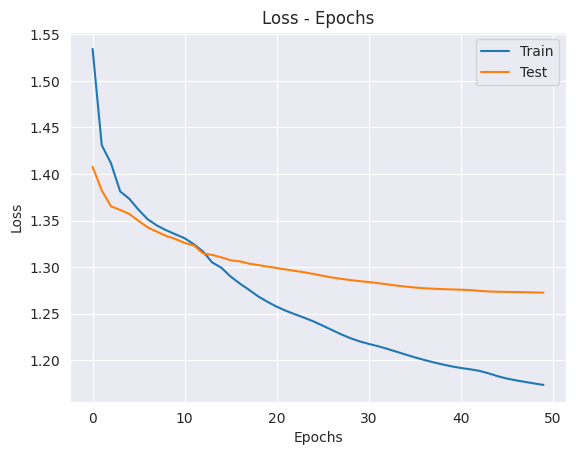

In [ ]:
plot_model_loss_metrics(mean_loss_train,mean_loss_test)

In [ ]:
# Plotting the F1 metrics
def plot_model_f1_metrics(mean_f1_scores_train,mean_f1_scores_test):
  plt.plot(mean_f1_scores_train,label='Train')
  plt.plot(mean_f1_scores_test,label='Test')
  plt.title('F1 - Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('F1')
  plt.legend()
  plt.show()

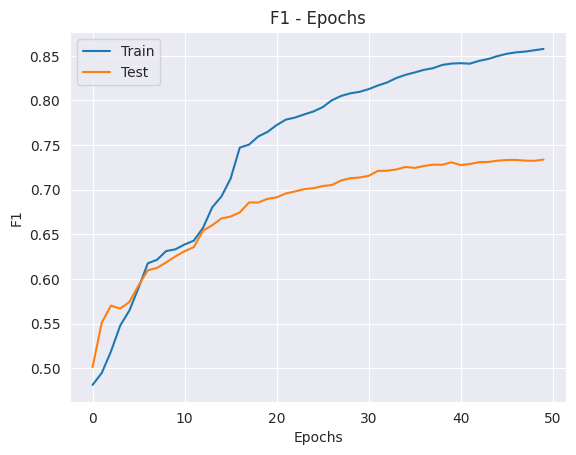

In [ ]:
plot_model_f1_metrics(mean_f1_scores_train,mean_f1_scores_test)

In [ ]:
with torch.no_grad():
     model.eval()
     for inputs,targets in test_loader:
          inputs,targets = inputs.to(device),targets.to(device)
          outputs = model(inputs)
          break

Accuracy: 0.7891
Precision: 0.7719
Recall: 0.7891
F1 Score: 0.7752
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.86      0.69        14
           1       0.29      0.14      0.19        14
           2       0.33      0.50      0.40        14
           3       0.29      0.50      0.37        14
           4       0.00      0.00      0.00        14
           5       0.95      0.94      0.94       186

    accuracy                           0.79       256
   macro avg       0.41      0.49      0.43       256
weighted avg       0.77      0.79      0.78       256



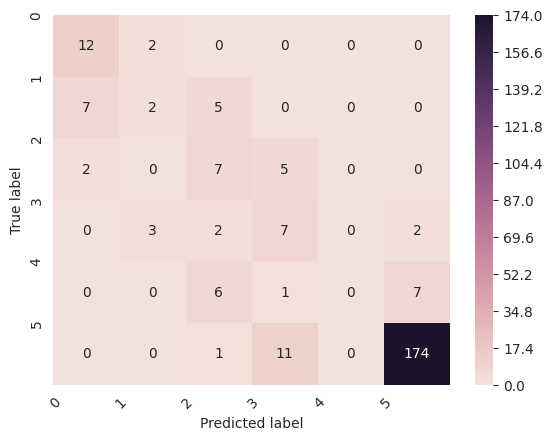

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

# Evaluate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

def plot_confusion_matrix(y_true, y_pred, classes, threshold_value=50):
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    fig, ax = plt.subplots()

    # Saturate the colors in the colormap
    cmap = sns.cubehelix_palette(dark=0.1, light=0.9, as_cmap=True)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, ax=ax)

    # Set labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.linspace(0, cm.max(), 11))


y_true = targets.argmax(dim=1).cpu().numpy().reshape(targets.size(0))
y_pred = outputs.argmax(dim=1).cpu().numpy()

# Get unique class labels
classes = unique_labels(y_true, y_pred)

# Calculate metrics
accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes)

# Print classification report
report = classification_report(y_true, y_pred, target_names=[str(cls) for cls in classes])
print("Classification Report:\n", report)

plt.show()


In [ ]:
PATH = '/content/drive/MyDrive/CMAPSSData/saved_model.pth'
torch.save(model.state_dict(), PATH)

# LSTM

In [ ]:
class Flatten2d(nn.Module):
    def __init__(self,n_neurons_flatten):
      super(Flatten2d,self).__init__()
      self.n_neurons_flatten = n_neurons_flatten
    def forward(self, x):
        return x.contiguous().view(-1,self.n_neurons_flatten)

class SimpleLSTM(nn.Module):
  def __init__(self,
               input_size,
               hidden_size,
               sequence_length,
               num_layers,
               rnn_activation_function,
               fc_activation_function,
               final_activation_function,
               fc_num_neurons,
               num_classes,
               device):

    super(SimpleLSTM,self).__init__()

    self.L = sequence_length
    self.Hin = input_size
    self.Hout = hidden_size
    self.Hcell = hidden_size
    self.rnn_activation_function = rnn_activation_function
    self.num_layers = num_layers
    self.final_activation_function = final_activation_function
    self.num_classes = num_classes
    self.fc_num_neurons = fc_num_neurons

    self.input_shape = (self.L,self.Hin)
    self.lstm = nn.LSTM(input_size=self.Hin,
                        hidden_size=self.Hcell,
                        num_layers=self.num_layers,
                        batch_first=True)
    self.n_neurons_flatten = int(self.Hout*self.L)
    self.flatten = Flatten2d(self.n_neurons_flatten)
    self.fc = nn.Sequential(nn.Linear(self.n_neurons_flatten,self.fc_num_neurons),
                            fc_activation_function(),
                            nn.Linear(self.fc_num_neurons,self.num_classes))
    self.device = device


  def forward(self,x):

    x,_ = self.lstm(x)
    x = self.flatten(x)
    x = self.fc(x)
    x = self.final_activation_function(x)
    return x

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.999)

In [ ]:
mean_loss_train,mean_loss_test,mean_f1_scores_train,mean_f1_scores_test = train_model(model,device,train_loader,test_loader,optimizer,criterion,scheduler,n_epochs=20)

Epoch 0/20, Train Loss: 1.4527, Test Loss:1.4265, F1 Score Train: 0.4534, F1 Score Test: 0.4795, Learning Rate: 0.000999
Epoch 1/20, Train Loss: 1.4761, Test Loss:1.4265, F1 Score Train: 0.4323, F1 Score Test: 0.4795, Learning Rate: 0.000998001
Epoch 2/20, Train Loss: 1.4599, Test Loss:1.4265, F1 Score Train: 0.4414, F1 Score Test: 0.4795, Learning Rate: 0.000997002999
Epoch 3/20, Train Loss: 1.4599, Test Loss:1.4265, F1 Score Train: 0.4414, F1 Score Test: 0.4795, Learning Rate: 0.000996005996001
Epoch 4/20, Train Loss: 1.4599, Test Loss:1.4265, F1 Score Train: 0.4414, F1 Score Test: 0.4795, Learning Rate: 0.000995009990004999
Epoch 5/20, Train Loss: 1.4599, Test Loss:1.4265, F1 Score Train: 0.4414, F1 Score Test: 0.4795, Learning Rate: 0.000994014980014994
Epoch 6/20, Train Loss: 1.4599, Test Loss:1.4265, F1 Score Train: 0.4414, F1 Score Test: 0.4795, Learning Rate: 0.0009930209650349789
Epoch 7/20, Train Loss: 1.4599, Test Loss:1.4265, F1 Score Train: 0.4414, F1 Score Test: 0.4795, L

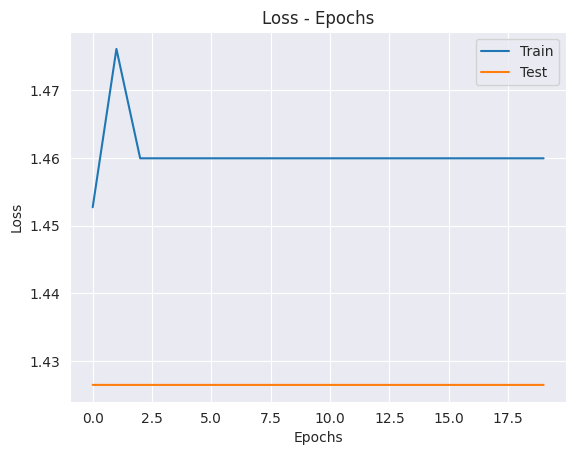

In [ ]:
plot_model_loss_metrics(mean_loss_train,mean_loss_test)

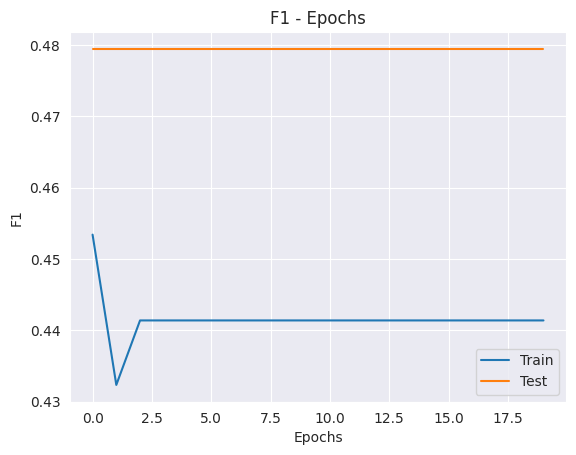

In [ ]:
plot_model_f1_metrics(mean_f1_scores_train,mean_f1_scores_test)

In [ ]:
with torch.no_grad():
     model.eval()
     for inputs,targets in test_loader:
          inputs,targets = inputs.to(device),targets.to(device)
          outputs_lstm = model(inputs)
          break

Accuracy: 0.7266
Precision: 0.5279
Recall: 0.7266
F1 Score: 0.6115
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        14
           5       0.73      1.00      0.84       186

    accuracy                           0.73       256
   macro avg       0.12      0.17      0.14       256
weighted avg       0.53      0.73      0.61       256



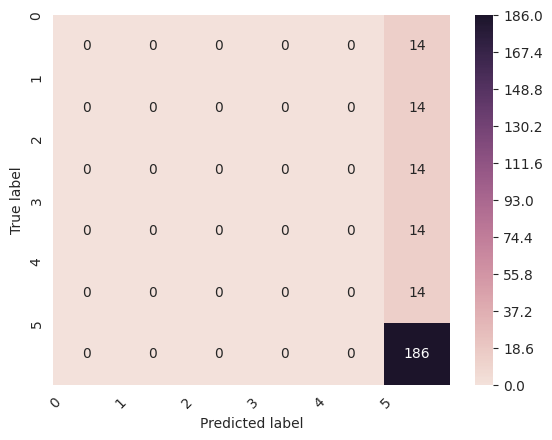

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

def plot_confusion_matrix(y_true, y_pred, classes, threshold_value=50):
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()

    # Saturate the colors in the colormap
    cmap = sns.cubehelix_palette(dark=0.1, light=0.9, as_cmap=True)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, ax=ax)

    # Set labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.linspace(0, cm.max(), 11))


y_true = targets.argmax(dim=1).cpu().numpy().reshape(targets.size(0))
y_pred = outputs_lstm.argmax(dim=1).cpu().numpy()

classes = unique_labels(y_true, y_pred)

# Calculate metrics
accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

plot_confusion_matrix(y_true, y_pred, classes)

report = classification_report(y_true, y_pred, target_names=[str(cls) for cls in classes])
print("Classification Report:\n", report)

plt.show()


# Maintenance Planning

Optmization problem:

Consider the following cost function:

$$
C = C_m \cdot \mathbb{P}[p = M | X = M]\cdot \hat{P} \cdot x +
 C_f \cdot \mathbb{P}[p = N | X = m]\cdot (1-\hat{P})(1-x) + C_m \cdot \mathbb{P}[p = M | X = n]\cdot \hat{P} \cdot x + C_f \mathbb{P}[p = N | X = n]\cdot (1-\hat{P}) \cdot (1-x)
$$

In [ ]:
prob = {'true_positive':0.963, 'false_negative':0.37, 'false_positive':0.213, 'true_negative':0.787}
cf = 10
cm = 1

In [ ]:
def total_cost(x, phat, prob, cm=1, cf=10):
  return cm*prob['true_positive']*phat*x + cf*prob['false_negative']*(1 - phat)*(1-x) + cm*prob['false_positive']*phat*x + cf*prob['true_negative']*(1-phat)*(1-x)

total_cost(1, 0.6, prob)


0.7056

In [ ]:
saved_model = SimpleRNN(input_size=14,
                  hidden_size=128,
                  sequence_length=T,
                  num_layers=1,
                  rnn_activation_function='tanh',
                  fc_activation_function=nn.GELU,
                  final_activation_function = nn.Softmax(dim=1),
                  fc_num_neurons=128,
                  num_classes=6,
                  device=device
                  )

saved_model.to(device)

PATH = '/content/drive/MyDrive/CMAPSSData/saved_model.pth'
saved_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
#Get predictions
results = None
machine = 0
with torch.no_grad():
  input = torch.tensor(np.array(X_schedule[machine]).astype('float32')).to(device)
  expected_output = y_schedule[machine]
  results = saved_model(input)

In [ ]:
#Get predictions for all machines

results_global = []

for machine in range(X_schedule.shape[0]):

  with torch.no_grad():
    input = torch.tensor(np.array(X_schedule[machine]).astype('float32')).to(device)
    expected_output = y_schedule[machine]
    results = saved_model(input)

  results_global.append(results)


In [ ]:
def classes_to_rul(classes):
  c = np.argmax(classes)
  return c

In [ ]:
def calculate_actions(results, y_schedule):
  C = np.array([1,5,10,20,40,50,100,500,1000,2000]) # Different cost values that will be tested

  p = []
  overall_actions = []
  for cf in C:
    for cm in C:
      costs = []
      action = []
      for prob_hat, RUL in zip(results,y_schedule):
        phat = prob_hat[-1]
        costs.append(max(total_cost(0, phat.item(), prob, cm, cf), total_cost(1, phat.item(), prob, cm, cf)))
        action.append(0 if total_cost(0, phat.item(), prob, cm, cf) < total_cost(1, phat.item(), prob, cm, cf) else 1)
      p.append(sum(costs)/len(prob_hat))
      overall_actions.append(sum(action)/len(action))

  optCost = np.array(p)

  overall_actions = np.array(overall_actions)

  return overall_actions

  print(overall_actions)

In [ ]:
all_actions = []

for result in results_global:

  action = calculate_actions(results, y_schedule)
  all_actions.append(action)


In [ ]:
np.mean(np.array(all_actions), axis=0)

array([0.32857143, 0.3       , 0.27142857, 0.25714286, 0.25714286,
       0.25714286, 0.25714286, 0.24285714, 0.24285714, 0.15714286,
       0.34285714, 0.32857143, 0.31428571, 0.3       , 0.27142857,
       0.27142857, 0.25714286, 0.25714286, 0.25714286, 0.25714286,
       0.35714286, 0.34285714, 0.32857143, 0.31428571, 0.3       ,
       0.3       , 0.27142857, 0.25714286, 0.25714286, 0.25714286,
       0.35714286, 0.34285714, 0.34285714, 0.32857143, 0.31428571,
       0.31428571, 0.3       , 0.25714286, 0.25714286, 0.25714286,
       0.35714286, 0.35714286, 0.34285714, 0.34285714, 0.32857143,
       0.32857143, 0.31428571, 0.27142857, 0.25714286, 0.25714286,
       0.35714286, 0.35714286, 0.34285714, 0.34285714, 0.32857143,
       0.32857143, 0.31428571, 0.27142857, 0.25714286, 0.25714286,
       0.4       , 0.35714286, 0.35714286, 0.34285714, 0.34285714,
       0.34285714, 0.32857143, 0.3       , 0.27142857, 0.25714286,
       0.45714286, 0.4       , 0.35714286, 0.35714286, 0.35714

In [ ]:
C = np.array([1,5,10,20,40,50,100,500,1000,2000]) # Different cost values that will be tested

p = []
overall_actions = []
for cf in C:
  for cm in C:
    costs = []
    action = []
    for prob_hat, RUL in zip(results,y_schedule):
      phat = prob_hat[-1]
      costs.append(max(total_cost(0, phat.item(), prob, cm, cf), total_cost(1, phat.item(), prob, cm, cf)))
      action.append(0 if total_cost(0, phat.item(), prob, cm, cf) < total_cost(1, phat.item(), prob, cm, cf) else 1)
    p.append(sum(costs)/len(prob_hat))
    overall_actions.append(sum(action)/len(action))

optCost = np.array(p)

overall_actions = np.array(overall_actions)

In [ ]:
overall_actions # percentage of times we're repairing the engine

array([0.32857143, 0.3       , 0.27142857, 0.25714286, 0.25714286,
       0.25714286, 0.25714286, 0.24285714, 0.24285714, 0.15714286,
       0.34285714, 0.32857143, 0.31428571, 0.3       , 0.27142857,
       0.27142857, 0.25714286, 0.25714286, 0.25714286, 0.25714286,
       0.35714286, 0.34285714, 0.32857143, 0.31428571, 0.3       ,
       0.3       , 0.27142857, 0.25714286, 0.25714286, 0.25714286,
       0.35714286, 0.34285714, 0.34285714, 0.32857143, 0.31428571,
       0.31428571, 0.3       , 0.25714286, 0.25714286, 0.25714286,
       0.35714286, 0.35714286, 0.34285714, 0.34285714, 0.32857143,
       0.32857143, 0.31428571, 0.27142857, 0.25714286, 0.25714286,
       0.35714286, 0.35714286, 0.34285714, 0.34285714, 0.32857143,
       0.32857143, 0.31428571, 0.27142857, 0.25714286, 0.25714286,
       0.4       , 0.35714286, 0.35714286, 0.34285714, 0.34285714,
       0.34285714, 0.32857143, 0.3       , 0.27142857, 0.25714286,
       0.45714286, 0.4       , 0.35714286, 0.35714286, 0.35714

In [ ]:
for prob_hat, RUL in zip(results,y_schedule):
  phat = prob_hat[-1]
  print(f"REPAIR - {classes_to_rul(RUL)}" if total_cost(1, phat, prob) < total_cost(0, phat, prob) else f"DO NOT REPAIR - {classes_to_rul(RUL)}")

DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 4
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 3
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 1
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
DO NOT REPAIR - 5
REPAIR - 5
REPAIR - 5
REPAIR - 4
REPAIR - 5
REPAIR - 2
REPAIR - 5
REPAIR - 5
REPAIR - 5
REPAIR - 5
REPAIR - 5
REPAIR - 5
REPAIR - 5
REPAIR - 5
REPAIR - 5
REPAIR - 5
REPAIR - 5
REPAIR - 5
REP

#### Evaluate Maintenance Plan

*   Compare maintenance decisions with actual RUL data
*   Analyze the effectiveness & adjust threshold and cost parameters based on performance

Sensibility Test

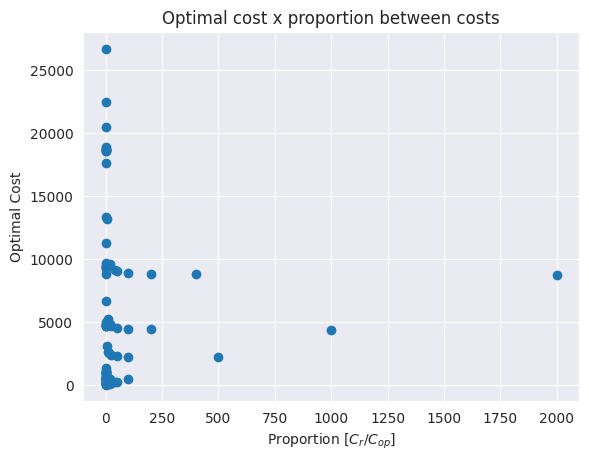

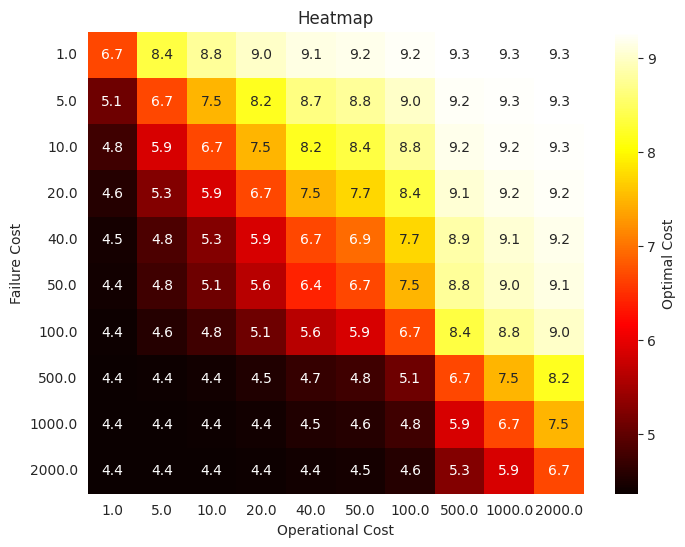

<Figure size 640x480 with 0 Axes>

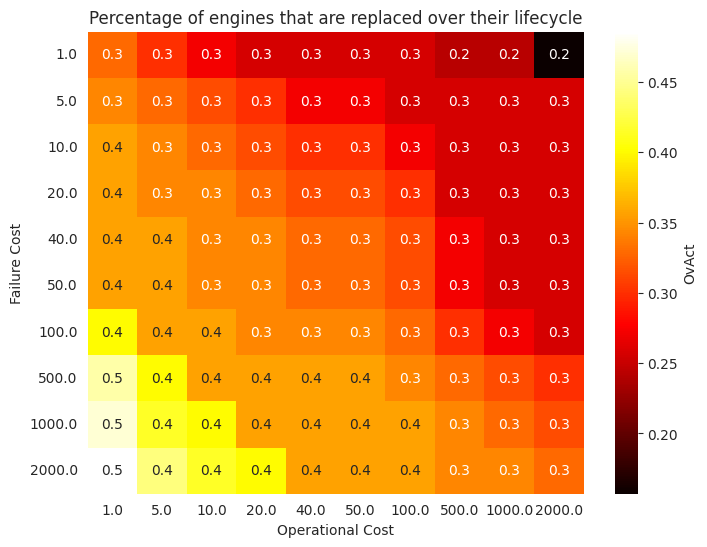

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
from itertools import product
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product


# Data

C = np.array([1,5,10,20,40,50,100,500,1000,2000]) # Different cost values that will be tested
permutations = np.array(list(product(C,C)))
#optCost = 10-np.linspace(0,10,len(permutations)) # vector that receives the optimal cost
proportion = [permutations[k][0] / permutations[k][1] for k in range(len(permutations))]
# plot 1
plt.title('Optimal cost x proportion between costs')
plt.plot(proportion, optCost,'o')
plt.xlabel('Proportion [$C_{r}/C_{op}$]')
plt.ylabel('Optimal Cost')

for i, _ in enumerate(optCost):
  optCost[i] = optCost[i]/(sum(permutations[i]))

data = np.column_stack([permutations, optCost])
df = pd.DataFrame(data, columns=['Repair Cost','Operational Cost', 'Optimal Cost'])

# heatmap
heatmap_data = df.pivot('Repair Cost', 'Operational Cost', 'Optimal Cost').fillna(0)

#Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap='hot', annot=True, fmt='.1f', cbar_kws={'label': 'Optimal Cost'})
plt.title('Heatmap')
plt.xlabel('Operational Cost')
plt.ylabel('Failure Cost')
plt.show()
plt.figure()

data2 = np.column_stack([permutations, overall_actions])
df2 = pd.DataFrame(data2, columns=['Repair Cost','Operational Cost', 'OvAct'])

# heatmap
heatmap_data2 = df2.pivot('Repair Cost', 'Operational Cost', 'OvAct').fillna(0)

#Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data2, cmap='hot', annot=True, fmt='.1f', cbar_kws={'label': 'OvAct'})
plt.title('Percentage of engines that are replaced over their lifecycle')
plt.xlabel('Operational Cost')
plt.ylabel('Failure Cost')
plt.show()
plt.figure()

